In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product

In [9]:
class ForecastEquityData:
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.csv_files = data_folder + '/csv_files'
    def load_data(self):
        df = {}
        tickers = ['AAPL', 'BTC-USD']
        for file in os.listdir(self.csv_files):
            for i in range(len(tickers)):
                if file == tickers[i] + '.csv':
                    df[i] = pd.read_csv(self.csv_files + '/'+file, index_col = ['Date'])
        self.data = df
    """
    The following functions attempt to smooth out time data and pick up the current and future trends
    """

    
    def moving_average(self, data, window, scale = 1.96, plot_intervals = True):
        '''
        Function to smooth the time data using moving average and plot it
        Paramaters:
        data(Pandas.TimeSeries): Data to smooth out and plot
        window(integer): How many days the data should be looked back on

        scale(float): How the upper and the lower bound plots should be scaled
        plot_intervals(bool): whether the intervals should be plotted or not


        '''
        rolling_mean = data.rolling(window=window).mean()
    
        plt.figure(figsize=(17,8))
        plt.title('Moving average\n window size = {}'.format(window))
        plt.plot(data.index, rolling_mean, 'g', label='Rolling mean trend')
    
        #Plot confidence intervals for smoothed values
        if plot_intervals:
            mae = mean_absolute_error(data[window:], rolling_mean[window:])
            deviation = np.std(data[window:] - rolling_mean[window:])
            lower_bound = rolling_mean - (mae + scale * deviation)
            upper_bound = rolling_mean + (mae + scale * deviation)
            plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
            plt.plot(lower_bound, 'r--')
            
        plt.plot(data[window:], label='Actual values')
        plt.legend(loc='best')
        plt.grid(True)
        plt.savefig('moving_average.png')
        plt.show()
    '''
    Function to smooth time data using exponential moving average
    '''
    def exponential_smoothing(self, data, alpha):
        res = [data[0]]
        for n in range(1, len(data)):
            res.append(alpha * data[n] + (1 - alpha) * data[n-1])
        return res    
    def plot_exponential(self, data, alphas):
        plt.figure(figsize= (20,12))
        for alpha in alphas:
            plt.plot(self.exponential_smoothing(data, alpha), label="Alpha {}".format(alpha))
        plt.plot(data.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        plt.savefig('expo_smoothing.png')
        plt.show()
    def double_exponential_smoothing(self, series, alpha, beta):

        result = [series[0]]
        for n in range(1, len(series)+1):
            if n == 1:
                level, trend = series[0], series[1] - series[0]
            if n >= len(series): # forecasting
                value = result[-1]
            else:
                value = series[n]
            last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
            trend = beta * (level - last_level) + (1 - beta) * trend
            result.append(level + trend)
        return result

    def plot_double_exponential_smoothing(self, series, alphas, betas):
     
        plt.figure(figsize=(17, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(self.double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        plt.savefig('double_expo.png')
        plt.show()
    """
    The following functions attempt to station and model the data using
    the SARIMA method
    """
    def tsplot(self, y, lags=None, figsize=(12, 7), style='bmh'):
    
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        
        with plt.style.context(style='bmh'):
            fig = plt.figure(figsize=figsize)
            layout = (2,2)
            ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
            acf_ax = plt.subplot2grid(layout, (1,0))
            pacf_ax = plt.subplot2grid(layout, (1,1))
        
            y.plot(ax=ts_ax)
            p_value = sm.tsa.stattools.adfuller(y)[1]
            ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
            smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
            smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
            plt.tight_layout()

    def run_SARIMA(self, data):
        results = []
        best_aic = float('inf')
        ps = range(0, 5)
        d = 1
        qs = range(0, 5)
        Ps = range(0, 5)
        D = 1
        Qs = range(0, 5)
        s = 5

        parameters = product(ps, qs, Ps, Qs)
        parameters_list = list(parameters)
        #for param in parameters_list:
        for param in parameters_list:
            try: model = sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            except:
                continue
            print('RAN SARIMA model')

            
        aic = model.aic
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
        result_table = pd.DataFrame(results)
        result_table.columns = ['parameters', 'aic']
        #Sort in ascending order, lower AIC is better
        result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
        return result_table
    def best_SARIMA(self, data):
        result_table = self.run_SARIMA(self.data_diff)
        p, q, P, Q = result_table.parameters[0]
        d = 1 
        s = 5
        D = 1
        best_model = sm.tsa.statespace.SARIMAX(data, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)
        forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 10)
        print(forecast)
        print(best_model.summary())

    def SARIMA_plot(self):
        comparison = pd.DataFrame({'actual': [39371.04,40797.61,40254.55,38356.44,35566.66,33922.96,37316.36,39187.33,36825.37,36178.14, 35791.28],
                                    'predicted': [33419.864465,
                                        33898.040481,
                                        33831.856459,
                                        32910.397276,
                                        32805.854130,
                                        32233.372946,
                                        33063.792879,
                                        33432.321420,
                                        32869.179479,
                                           32485.672475,
                                            32384.017956]}, 
                          index = pd.date_range(start='2021-01-07', periods=11,))
        plt.figure(figsize=(17, 8))
        plt.plot(comparison.actual, label = 'actual')
        plt.plot(comparison.predicted, label = 'predicted')
        plt.title('Predicted closing price of MMM')
        plt.ylabel('Closing price ($)')
        plt.xlabel('Trading day')
        plt.legend()
        plt.grid(False)
        plt.savefig('SARIMA.png')
        plt.show()
        
        
    def ARIMA(self, data):
        train_data, test_data = data[0:int(len(data)*0.7)], data[int(len(data)*0.7):]
        training_data = train_data.values
        test_data = test_data.values
        history = [x for x in training_data]
        model_predictions = []
        N_test_observations = len(test_data)
        for time_point in range(N_test_observations):
            model = ARIMA(history, order=(4,1,0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            model_predictions.append(yhat)
            true_test_value = test_data[time_point]
            history.append(true_test_value)
        MSE_error = mean_squared_error(test_data, model_predictions)
        print('Testing Mean Squared Error is {}'.format(MSE_error))
        
        test_set_range = data[int(len(data)*0.7):].index
        plt.figure(figsize = (20,8))
        plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
        
        plt.plot(test_set_range, test_data, color='red', label='Actual Price')
        plt.title('BTC Prices Prediction')
        plt.xlabel('Date')
        plt.ylabel('Prices')
        plt.legend()
        plt.savefig('ARIMA.png')
        plt.show()

    def run_plots(self):
        self.load_data()
        self.moving_average(self.data[0]['Adj Close'], 30)
        self.moving_average(self.data[0]['Adj Close'], 90)
        self.plot_exponential(self.data[0]['Adj Close'], [1, 0.3])
        self.plot_double_exponential_smoothing(self.data[0]['Adj Close'], alphas=[0.8, 0.5], betas=[0.8, 0.5])
        self.tsplot(self.data[0]['Adj Close'], lags=30)
        self.data_diff = self.data[0]['Adj Close'] - self.data[0]['Adj Close'].shift(1)
        self.data_diff = self.data_diff.dropna()
        self.tsplot(self.data_diff, lags=30)
        self.SARIMA_plot()
        
    def run_ARIMA(self):
        self.ARIMA(self.data[1]['Adj Close'])







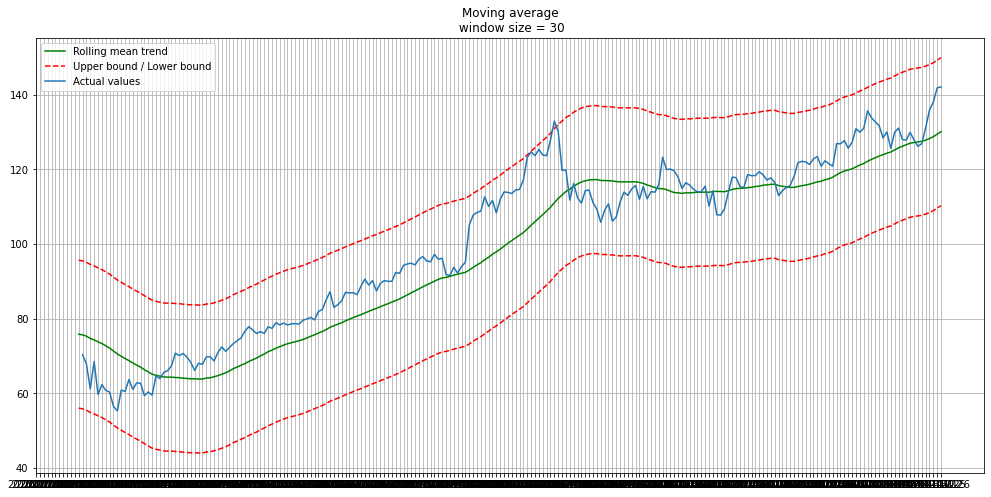

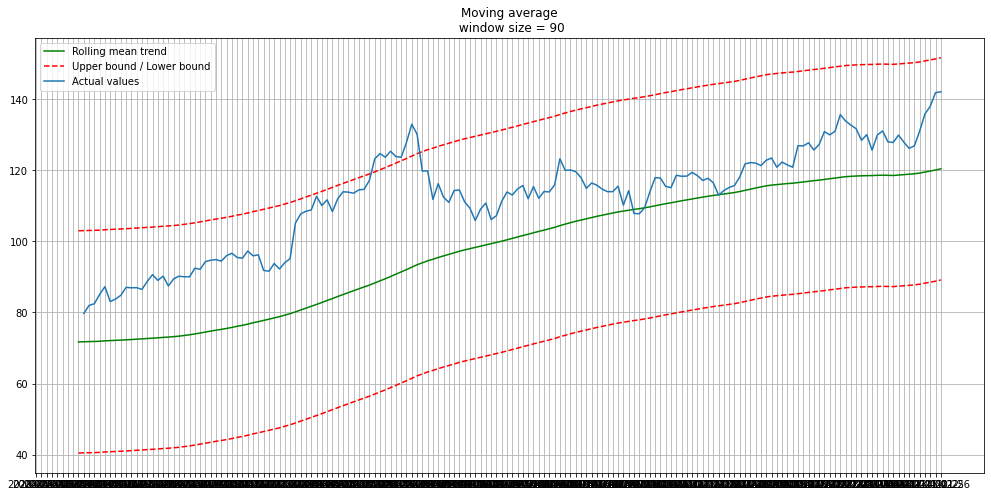

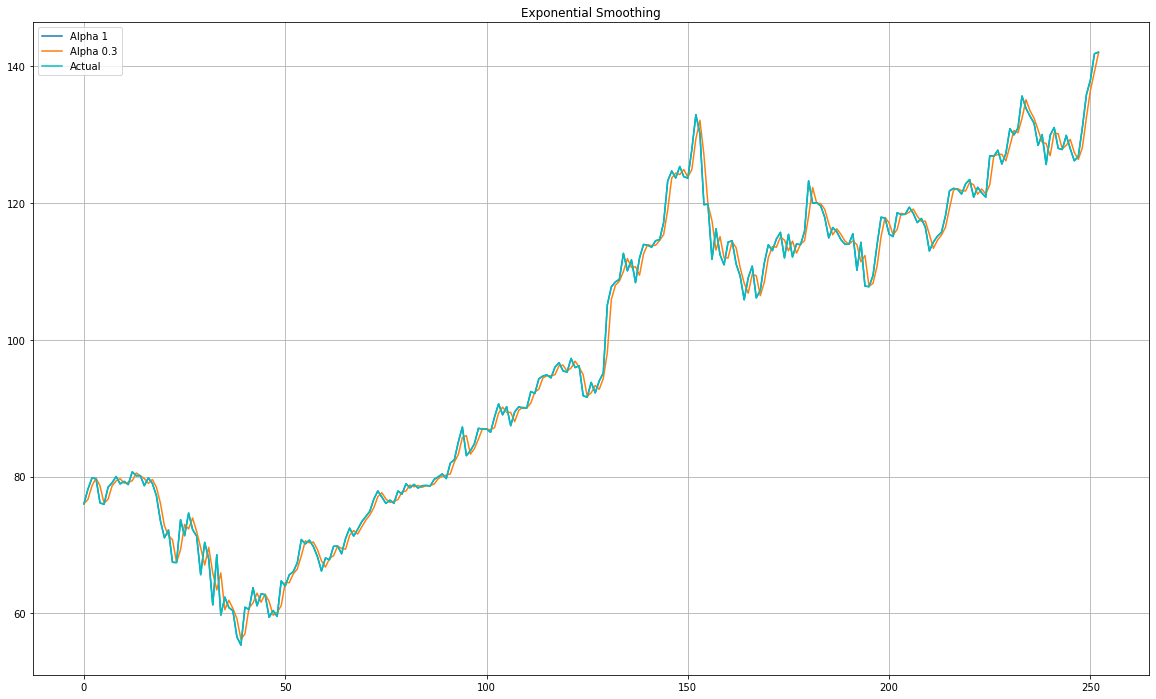

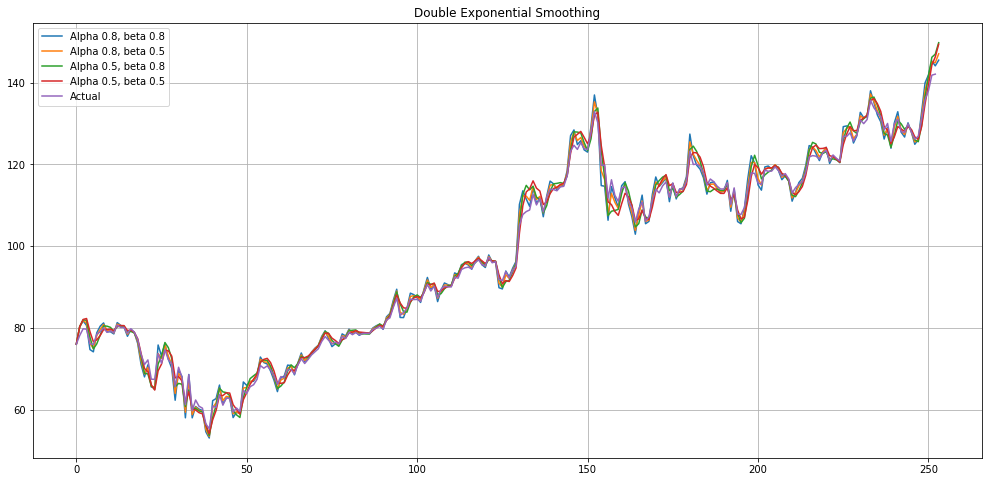

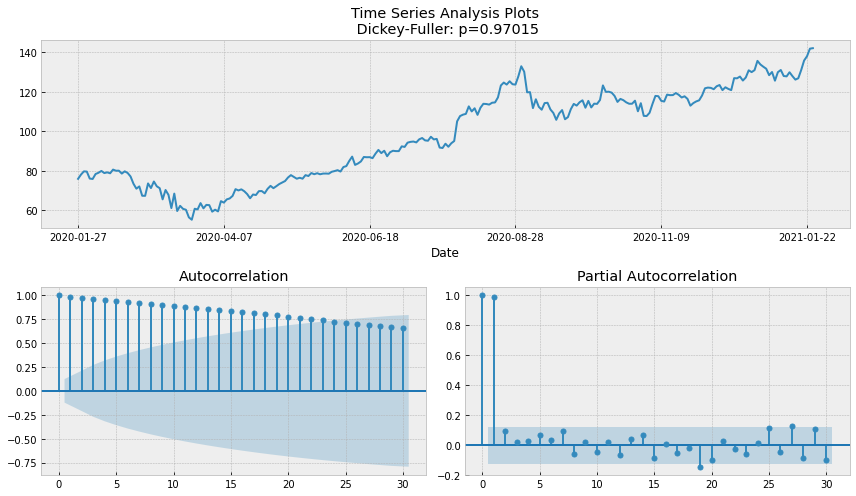

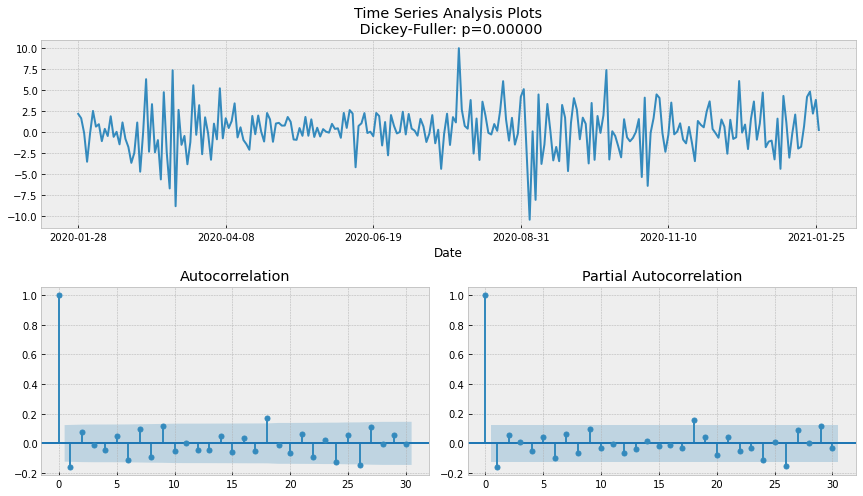

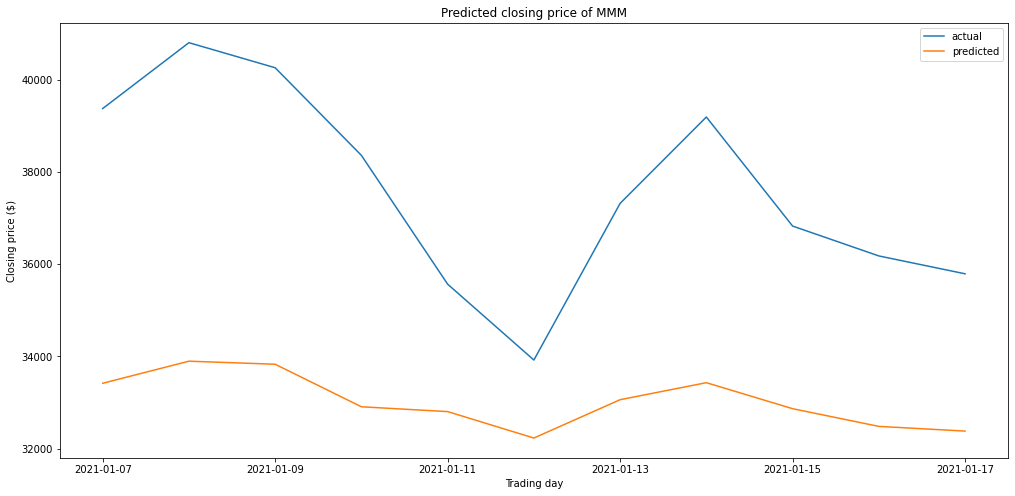

Testing Mean Squared Error is 1228464.9113993126


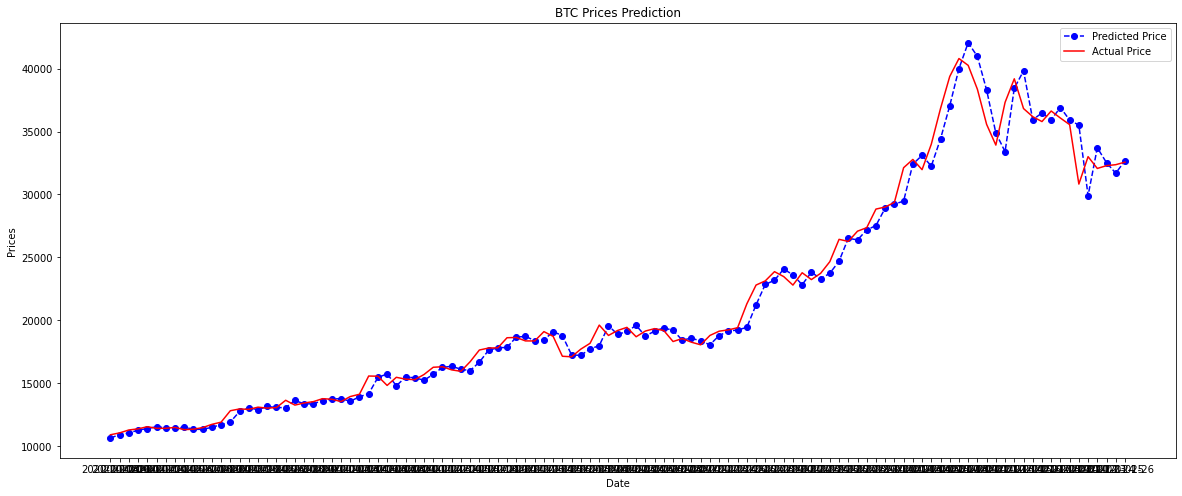

In [10]:
a = ForecastEquityData('../data')
a.run_plots()
a.run_ARIMA()